In [1]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
from aggmap import AggMap, AggModel, loadmap

from aggmap import show

np.random.seed(666) #just for reaptable results

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter

font = FontProperties()
font.set_style('italic')
font.set_size(20)

sns.set(style = 'white', font_scale=1.8)


In [2]:
def filter_df_by_zone(df,zone):
    x,y = zone
    x1, x2 = x
    y1, y2 = y
    dfx = df[(df.grid_x >= x1) & (df.grid_x <= x2)]
    new_df = dfx[(dfx.grid_y >= y1) & (dfx.grid_y <= y2)]
    return new_df

In [3]:
color = sns.color_palette("rainbow_r",15).as_hex() #PiYG
color = [color[7], color[5], color[3], color[1] ]

In [4]:
mp = pd.read_excel('./results/MP_importance.xlsx')
s0 = pd.read_excel('./results/Stage_0_importance.xlsx')
s12 = pd.read_excel('./results/Stage_I_II_importance.xlsx')
s34 = pd.read_excel('./results/Stage_III_IV_importance.xlsx')

In [5]:
df = mp[['feature_points', 'grid_x', 'grid_y', 'scatter_x', 'scatter_y', 'Subtypes', 'colors', 'MP_avg_imp']]
df = df.join(s0[s0.columns[-1]]).join(s12[s12.columns[-1]]).join(s34[s34.columns[-1]])

In [6]:
stages = ['MP_avg_imp', 'Stage_0_avg_imp', 'Stage_I_II_avg_imp','Stage_III_IV_avg_imp']
stage_names = ['MP', 'Stage 0', 'Stage I/II','Stage III/IV']

In [7]:
zoneA = [(0,19), (0,15)] # MP_avg_imp', 'Stage_0_avg_imp', 'Stage_I_II_avg_imp','Stage_III_IV_avg_imp'
zoneB = [(20,63), (2,15)] # MP_avg_imp', 'Stage_0_avg_imp', 'Stage_I_II_avg_imp'
zoneC = [(66,85), (0,15)] # Stage_I_II_avg_imp
zoneD = [(5,15), (16,65)] #'Stage_III_IV_avg_imp
zoneE = [(0,20), (66,86)] #'Stage_III_IV_avg_imp

zones = [zoneA, zoneB, zoneC, zoneD, zoneE]
zone_names =  ['zoneA', 'zoneB', 'zoneC', 'zoneD', 'zoneE']

topn = 5

In [8]:
zone_info = {}
for zone, zone_name in zip(zones, zone_names):
    #print(zone_name)
    dfnew = filter_df_by_zone(df, zone)
    dfnew['avg'] = dfnew[stages].mean(axis=1)
    dfnew = dfnew[dfnew['avg'] > 1.0]
    zone_info[zone_name] = dfnew.index.tolist()
    
res = []
for k, v in zone_info.items():
    res.append(pd.Series(k, index = v))
    
dfs = pd.concat(res).to_frame(name = 'Zones')
df2 = df.join(dfs)
df2.to_excel('./results/Stage_all.xlsx')

In [9]:
df2 = pd.read_excel('./results/NM_supplementary-2.xlsx',sheet_name='CRCM-S', index_col=0)

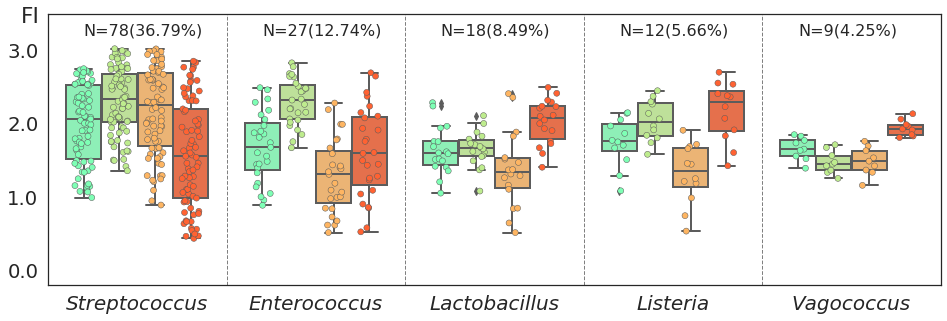

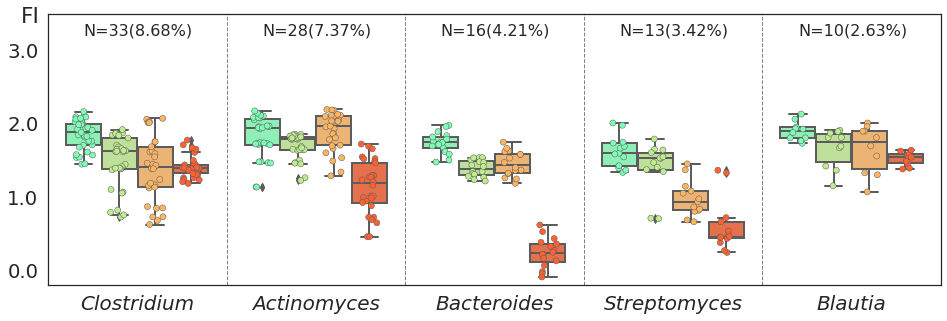

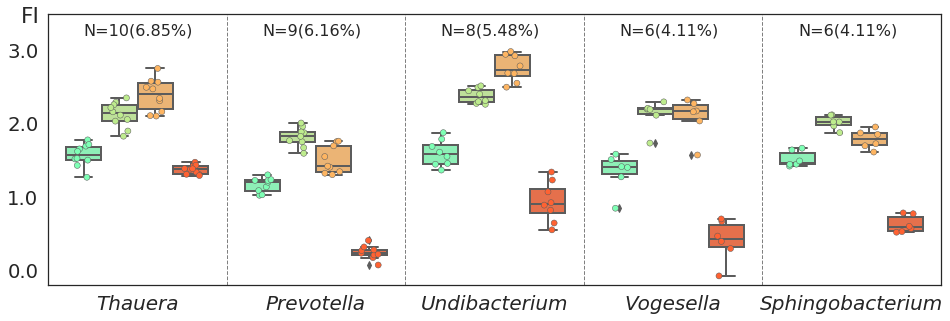

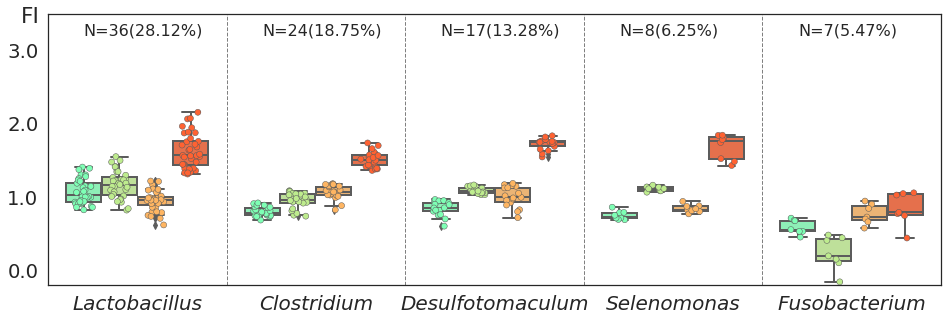

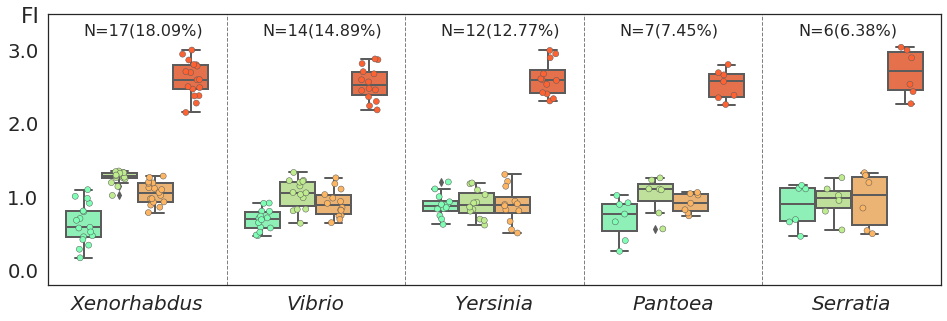

In [10]:
for zone, zone_name in zip(zones, zone_names):

    dfnew = df2[df2['Zones'] == zone_name]
    dfnew['species'] = dfnew.feature_points.apply(lambda x:x.split(' ')[0])
    m1 = dfnew.groupby('species').size().sort_values().iloc[-topn:].index.tolist()
    m2 = dfnew.groupby('species').size().sort_values().iloc[:-topn].index.tolist()
    s1 = dict(zip(m1, m1))
    s2 = dict(zip(m2, ['Others']*len(m2)))
    s1.update(s2)
    dfnew['group'] = dfnew.species.map(s1)

    dfn = dfnew.copy()
    
    dfnew = dfnew[dfnew['group'] != 'Others']
    order = dfnew.groupby('group').size().sort_values(ascending = False).index.tolist()

    res = []
    for stage,name in zip(stages,stage_names):
        df1 = dfnew[[stage, 'species', 'group']]
        df1['stage'] = name
        df1 = df1.rename(columns={stage:'FI'})
        res.append(df1)

    dfp = pd.concat(res,axis=0)
    #dfp = dfp[dfp.group != 'Others']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

    params = dict(data=dfp,
                  x='group',
                  y='FI',
                  hue='stage',
                  #jitter=0.25,
                  order=order,
                  dodge=True)
    # sns.violinplot(x="group", y="importance score", data=dfp,   hue = 'stage', inner=None,  order = order, color=".8", ax=ax)

    p = sns.stripplot(x="group", y="FI", hue = 'stage', order = order,
                      data=dfp, jitter=0.2, ax= ax , dodge=True, alpha=1,
                      size=6, linewidth = 0.5, palette=color)

    p_box = sns.boxplot(linewidth=2,**params, ax=ax, palette = color) #['#BBBBBB','#DDDDDD']

    handles,labels = p.get_legend_handles_labels()
    ax.legend().set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('FI', rotation = 0)
    ax.yaxis.set_label_coords(-0.02,0.95)

    ax.set_ylim(-0.2, 3.5)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax.set_xticklabels(labels = order, rotation=0, fontproperties=font)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)

    for i in [0.5, 1.5, 2.5, 3.5, 4.5]:
        ax.axvline(x=i, lw = 1, ls = '--', color = 'grey')

    d = dfnew.groupby('group').size().sort_values(ascending = False)
    d = d.to_frame(name = 'N')
    TN = dfn.groupby('group').size().sort_values(ascending = False).sum()
    d['P'] = d / TN
    for i in range(len(d)):
        n,p = d.iloc[i]
        percentage = "{:.2%}".format(p)
        v = "N=%d(%s)" % (n,percentage)
        x = i-0.3
        y = 3.2
        ax.text(x, y, v, fontsize=16)

    fig.savefig('./results/%s.png' % zone_name, bbox_inches='tight', dpi=400) 

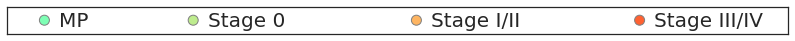

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,0.5))

x = [0,2,5,8]
y = [0]*len(x)

s = [100 for n in range(len(x))]
ax.scatter(x,y,s=s, c= color, edgecolors='0.5')
for i, j , v in zip(x, y, stage_names):
    ax.text(i + 0.2, j-0.09,  v, fontsize= 20)
    
ax.set_xlim(-0.5,10)
#ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_facecolor('#f2f2f2')

fig.savefig('./results/zone_legend.png', bbox_inches='tight', dpi=400) 

In [12]:
len(df)

7310

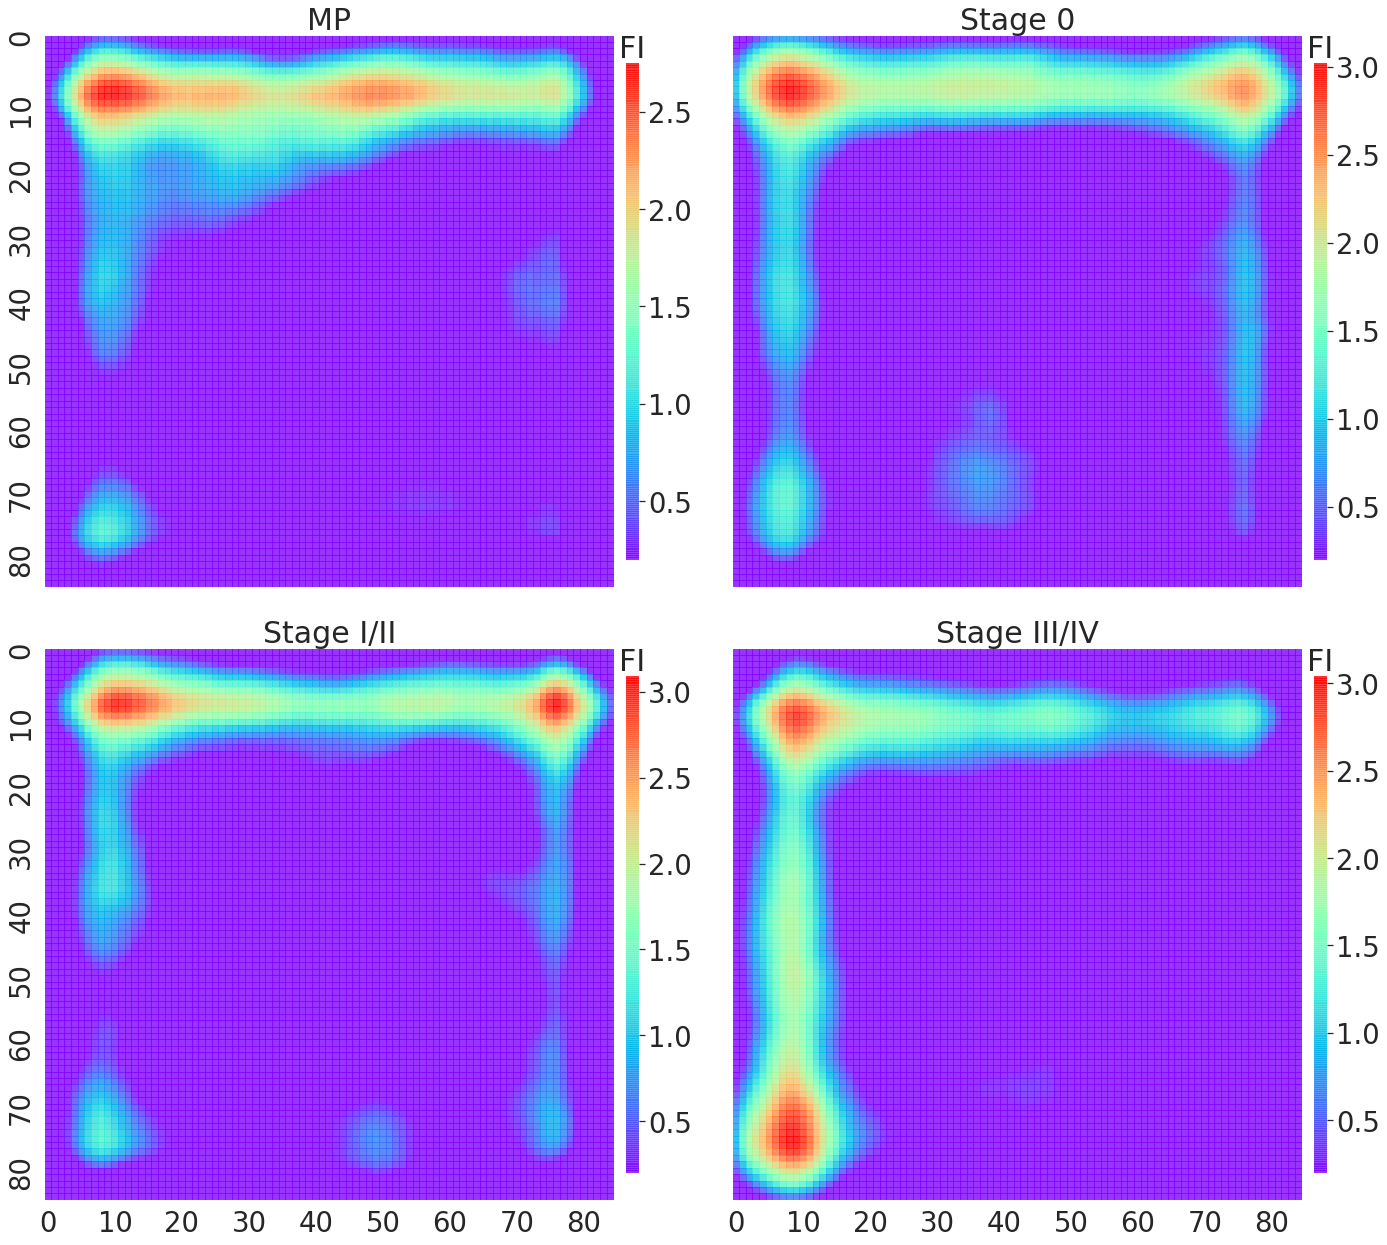

In [13]:
df = df.rename(columns = {'MP_avg_imp':'MP', 'Stage_0_avg_imp':'Stage 0',
                     'Stage_I_II_avg_imp':'Stage I/II', 'Stage_III_IV_avg_imp':'Stage III/IV'})
mpo = loadmap('./CRC_stage.mp')

sns.set(style='white',  font='sans-serif', font_scale=2.5)
fig, axes  = plt.subplots(2, 2, figsize=(20, 18), sharex=True, sharey=True)


for s, ax in zip(df.columns[-4:], axes.ravel()):

    IMPM = df[s] .values.reshape(*mpo._S.fmap_shape)

    cf = sns.heatmap(IMPM,  
                cmap = 'rainbow', alpha = 0.8, xticklabels=10, ax =ax,
                yticklabels=10, vmin = 0.2,
                cbar_kws = {'fraction':0.046, 'shrink':0.9, 'aspect': 40, 'pad':0.02, }) #  'orientation':'horizontal'
    ax.set_title(s)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_title('FI')

fig.tight_layout()
fig.savefig('./results/fmap_imp_4.png', bbox_inches='tight', dpi=400) 